<a href="https://colab.research.google.com/github/PerlaMolina/BMI212-AURA/blob/main/Aim%202/Late_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Lan Lan wrote the code in this notebook.
# load data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/widsdata/'
behavorial_data = pd.read_excel(file_path+'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
label_data = pd.read_excel(file_path+'TRAINING_SOLUTIONS.xlsx')
FC_data = pd.read_csv(file_path+ 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
FC_reduced = pd.read_csv(file_path+ 'autoencoder/FC_extracted.csv')

Mounted at /content/drive/


# data splitting and preprocessing
note for each modality:
- raw FC data are already in the range of [-1, 1], normalizing the data raises question about wheather we should normalize across each feature or within each subject, so they wouldn't be standardized
- extracted FC data were batch normalized by the autoencoder, so no standardization is needed
- behavorial data will be standardized for each feature and its columns not related to ADHD diagnosis are dropped
- subjects with NAN entries are dropped

In [ ]:
import pandas as pd
import numpy as np
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 0
seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
# merge everything first because need to drop subject with nan entries for all data
all_data_with_label = pd.merge(behavorial_data, label_data, how= 'left', on= ['participant_id'])
all_data_with_label = pd.merge(all_data_with_label, FC_data, how= 'left', on= ['participant_id']) # merge with raw FC data
all_data_with_label = pd.merge(all_data_with_label, FC_reduced, how= 'left', on= ['participant_id']) # merge with extracted FC data
all_data_with_label['stratify'] = all_data_with_label['Sex_F'].astype(str) + '_' + all_data_with_label['ADHD_Outcome'].astype(str)
# drop NAN
all_data_with_label = all_data_with_label.dropna()
# drop columns not related to ADHD: "EHQ_EHQ_Total" - Laterality Index (Score), "ColorVision_CV_Score" - Color vision test score
all_data_with_label = all_data_with_label.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan'])

# before splitting, standardize behavorial features

behavorial_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]


scaler = StandardScaler()
all_data_with_label[behavorial_columns_names] = scaler.fit_transform(all_data_with_label[behavorial_columns_names])


# splitting
train_all_subjects_raw, test_all_subjects_raw = train_test_split(all_data_with_label, test_size=0.3, stratify=all_data_with_label['stratify'])
print('training:')
print(train_all_subjects_raw['stratify'].value_counts())
print('testing:')
print(test_all_subjects_raw['stratify'].value_counts())
train_all_subjects_raw.reset_index(drop=True, inplace=True)
test_all_subjects_raw.reset_index(drop=True, inplace=True)

# training data for all subjects
train_data_all_subjects_X = train_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify', 'Unnamed: 0'])
train_data_all_subjects_y = train_all_subjects_raw['ADHD_Outcome']

# training data for female
train_data_female_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_female_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']


# training data for male
train_data_male_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_male_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']

# testing data for all subjects
test_data_all_subjects_X = test_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_all_subjects_y = test_all_subjects_raw['ADHD_Outcome']

# testing data for female
test_data_female_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_female_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']

# testing data for male
test_data_male_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_male_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']

training:
stratify
0_1    274
1_1    115
0_0    102
1_0     77
Name: count, dtype: int64
testing:
stratify
0_1    118
1_1     49
0_0     44
1_0     33
Name: count, dtype: int64


# single modality
For each modality, see which classifier performs the best and store the parameters for that classifier


In [ ]:
def make_data_dictionary(columns_to_select):

  #all variables not passed in are initialized perviously as global variables for this function
  data_dictionary = {
     'all_subjects': {
        'train_X': train_data_all_subjects_X[columns_to_select],
        'train_y': train_data_all_subjects_y,
        'test_X': test_data_all_subjects_X[columns_to_select],
        'test_y': test_data_all_subjects_y},
    'female': {
        'train_X': train_data_female_X[columns_to_select],
        'train_y': train_data_female_y,
        'test_X': test_data_female_X[columns_to_select],
        'test_y': test_data_female_y},
    'male': {
        'train_X': train_data_male_X[columns_to_select],
        'train_y': train_data_male_y,
        'test_X': test_data_male_X[columns_to_select],
        'test_y': test_data_male_y}
 }

  return data_dictionary

behavorial_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]

raw_FC_columns_names = [x for x in FC_data.columns if 'row' in x and 'column' in x and 'th' in x]

reduced_FC_columns_names = [x for x in FC_reduced.columns if 'extracted_FC' in x]

behavorial_data_dictionary = make_data_dictionary(behavorial_columns_names)
raw_FC_data_dictionary = make_data_dictionary(raw_FC_columns_names)
reduced_FC_data_dictionary = make_data_dictionary(reduced_FC_columns_names)

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pickle

def return_model_list(model_name):
    if model_name == 'SVC':
        return [
            ('linear', SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)),
            ('poly', SVC(kernel='poly', random_state=RANDOM_STATE, probability=True)),
            ('rbf', SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True))
        ]
    elif model_name == 'LinearSVC':
        return [
            ('l1', LinearSVC(penalty='l1', dual=False, random_state=RANDOM_STATE,  max_iter=10000)),
            ('l2', LinearSVC(penalty='l2', random_state=RANDOM_STATE,  max_iter=10000)),
        ] # defaulted to l2, no 'none' option

    elif model_name == 'LogisticRegression':
        return [
            ('l1', LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE,  max_iter=10000)),
            ('l2', LogisticRegression(penalty='l2', random_state=RANDOM_STATE,  max_iter=10000)),
            ('elasticnet', LogisticRegression(penalty='elasticnet', l1_ratio= 0.5,
                                               random_state=RANDOM_STATE, solver= 'saga',  max_iter=10000)), # only saga supports elastic net
            ('none', LogisticRegression(penalty=None, random_state=RANDOM_STATE))
        ]
    else:
        return None

def make_dictionary_for_results():

  results = {
    'SVC': {
        'linear': None,
        'poly': None,
        'rbf': None
    },
    'LinearSVC': {
        'l1': None,
        'l2': None,
    },
    'LogisticRegression': {
        'l1': None,
        'l2': None,
        'elasticnet': None,
        'none': None
    }
 }

  return results



def single_modality_evaluation(FC_data_dictionary):

    models_names = ['SVC', 'LinearSVC', 'LogisticRegression']

    all_record = {}


    for cohort in FC_data_dictionary.keys():

      record_cohort = make_dictionary_for_results()

      for model_name in models_names:
          model_list = return_model_list(model_name)

          for subtype, model in model_list:

            model.fit(FC_data_dictionary[cohort]['train_X'], FC_data_dictionary[cohort]['train_y'])

            if model_name == 'LinearSVC':

              decision_values = model.decision_function(FC_data_dictionary[cohort]['test_X'])
              proba_positive = 1 / (1 + np.exp(-decision_values))
              auroc = roc_auc_score(FC_data_dictionary[cohort]['test_y'], proba_positive)
              bal_acc = balanced_accuracy_score(FC_data_dictionary[cohort]['test_y'],
                                            model.predict(FC_data_dictionary[cohort]['test_X']))
            else:
              auroc = roc_auc_score(FC_data_dictionary[cohort]['test_y'], model.predict_proba(FC_data_dictionary[cohort]['test_X'])[:, 1])

              bal_acc = balanced_accuracy_score(FC_data_dictionary[cohort]['test_y'],
                                            model.predict(FC_data_dictionary[cohort]['test_X']))

            record_cohort[model_name][subtype] = (auroc, bal_acc)

      all_record[cohort] = record_cohort

    return all_record


# uncomment to evaluate the above models on single modalities
#raw_FC_data_alone = single_modality_evaluation(raw_FC_data_dictionary)
#behavorial_data_alone = single_modality_evaluation(behavorial_data_dictionary)
#reduced_FC_data_alone = single_modality_evaluation(behavorial_data_dictionary)

In [ ]:
import pickle

with open(file_path+'singleModality/raw_FC_data_alone.pkl', 'wb') as handle:
    pickle.dump(raw_FC_data_alone, handle)

with open(file_path+'singleModality/behavorial_data_alone.pkl', 'wb') as handle:
    pickle.dump(behavorial_data_alone, handle)

with open(file_path+'singleModality/reduced_FC_data_alone.pkl', 'wb') as handle:
    pickle.dump(reduced_FC_data_alone, handle)

In [ ]:
single_modality_dict = {
    'FC_raw': raw_FC_data_alone,
    'behavorial': behavorial_data_alone,
    'FC_extracted': reduced_FC_data_alone
}

def print_best_model_each_cohort(modality_dict):

  Best_model_each_cohort = {
    'male': {
        'FC_raw': None,
        'behavorial': None,
        'FC_extracted': None
    },
    'female': {
        'FC_raw': None,
        'behavorial': None,
        'FC_extracted': None
    },

    'all_subjects': {
        'FC_raw': None,
        'behavorial': None,
        'FC_extracted': None
    }
}

  modality_list = list(modality_dict.keys())

  cohort_list = list(modality_dict[modality_list[0]].keys())

  print('###########')
  for modality_type_i in modality_list:


    print(modality_type_i)

    modality_record = modality_dict[modality_type_i]

    for cohort in modality_record.keys():

      print(cohort)

      score = 0
      record = None

      for model in modality_record[cohort].keys():
        for subtype in modality_record[cohort][model].keys():
            auc, _ = modality_record[cohort][model][subtype]
            if auc > score:
              score = auc
              record = (model, subtype)

      print(record)
      print(np.round(score, 3))


      Best_model_each_cohort[cohort][modality_type_i] = record

    print('###########')

  return Best_model_each_cohort


Best_model_each_cohort = print_best_model_each_cohort(single_modality_dict)

NameError: name 'raw_FC_data_alone' is not defined

In [ ]:
with open(file_path+'LF/Best_model_each_cohort.pkl', 'wb') as handle:
    pickle.dump(Best_model_each_cohort, handle)

As one can see, these linear models do not seem to perform well for functional connectome data, even after feature extraction. I have tried training a simple neural net for the extracted FC features, but the loss is huge even after converging. See this notebook for the [extracted FC classifier](https://colab.research.google.com/drive/1nniR-P9V8fkMqjt8q8YNH9t4oUOJ8Pr9?usp=sharing) So even though we know that our late fusion classifier (stacking classifier) will heavily relies on the behavorial data's classifier, I will still implement them for the completeness of this project.

# Late Fusion: Stacking
- base classifier: best classifier for each modality
- meta classifier: SVC, logisticRegression

Modality selector function is made by cutomizing a transform function ([see reference here](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)).


For pipeline function, all intermediate steps are transform functions (that are capable to perform 'fit' and 'transform'), the last step can be a classifier that is capable for doing 'predict').  [see reference here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
with open(file_path+'LF/Best_model_each_cohort.pkl', 'rb') as handle:
    Best_model_each_cohort = pickle.load(handle)

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import StackingClassifier
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt

# customize transform function
class ModalitySelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        # feature_names = a list of column names
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is a dataframe, only returning columns we want
        return X[self.feature_names]

In [ ]:
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def print_metrics(confusion_matrix, y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix.ravel()
  sensitivity = tp / (tp + fn)  # True Positive Rate
  specificity = tn / (tn + fp)
  acc = balanced_accuracy_score(y_true, y_pred)

  print(f'Sensitivity (Recall), Specificity, Balanced Accuracy: { sensitivity:.4f} {specificity: .4f} {acc: .4f}')


def find_best_threshold(y_prob, y_true):

  """
    find the best decision threshold for the model using balanced accuracy
    y_prob: model prediction probability
    y_true: true label
  """

  thresholds = np.linspace(0.01, 0.99, 100)
  balanced_accuracies = [balanced_accuracy_score(y_true, (y_prob >= t).astype(int)) for t in thresholds]
  optimal_threshold = thresholds[np.argmax(balanced_accuracies)]

  return optimal_threshold


cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


hyperparameter_tuning_dict = { ('LogisticRegression', 'elasticnet'): {
            'C': [0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        },
        ('LogisticRegression', 'l1'): {
            'C': [0.01, 0.1, 1, 10, 100],
        },
        ('LogisticRegression', 'l2'): {
            'C': [0.01, 0.1, 1, 10, 100],
        },
        ('SVC', 'rbf'): {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto']
        },
        ('SVC', 'linear'): {
            'C': [0.01, 0.1, 1, 10, 100],
        },
        ('SVC', 'poly'): {
            'C': [0.01, 0.1, 1, 10, 100],
            'degree': [2, 3, 4],
        }
}


def tune_model_parameters(modality_type, cohort):

  """
  modality_type: behavioral_raw_FC, behavioral_extracted_FC
  cohort: male, female, all_subjects
  """
  model_name, subtype = Best_model_each_cohort[cohort][modality_type]
  MODEL = [model_instance_i for subtype_i, model_instance_i in return_model_list(model_name) if subtype_i == subtype][0]

   # raw_FC_data_dictionary, behavorial_data_dictionary, behavorial_data_dictionary

  if modality_type == 'behavioral':
    modality_data_dict = behavorial_data_dictionary
  elif modality_type == 'FC_raw':
    modality_data_dict = raw_FC_data_dictionary
  elif modality_type == 'FC_extracted':
    modality_data_dict = reduced_FC_data_dictionary


  train_x, train_y = modality_data_dict[cohort]['train_X'],  modality_data_dict[cohort]['train_y']
  test_x, test_y = modality_data_dict[cohort]['test_X'],  modality_data_dict[cohort]['test_y']


  cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
  param_grid = hyperparameter_tuning_dict[(model_name, subtype)]
  grid_search = GridSearchCV(MODEL, param_grid, cv=cv_splitter, scoring= 'balanced_accuracy', n_jobs=-1)
  grid_search.fit(train_x, train_y)

  return grid_search.best_estimator_


def train_and_test_model(modality_type_1, modality_type_2, cohort):

  """
  modality_type: behavioral, FC_raw, FC_extracted
  cohort: male, female, all_subjects
  """

  columns_dict = {
      'behavorial': behavorial_columns_names,
      'FC_raw': raw_FC_columns_names,
      'FC_extracted': reduced_FC_columns_names
  }

  modality_data_dict = {
      'behavorial': behavorial_data_dictionary,
      'FC_raw': raw_FC_data_dictionary,
      'FC_extracted': reduced_FC_data_dictionary
  }

  # model 1/ modality_type_1

  model_name_1, subtype_1 = Best_model_each_cohort[cohort][modality_type_1]
  MODEL_1 = clone (tune_model_parameters(modality_type_1, cohort))


   #[model_instance_i for subtype_i, model_instance_i in return_model_list(model_name_1) if subtype_i == subtype_1][0]


  pipe_1 = Pipeline([
    ('selector', ModalitySelector(columns_dict[modality_type_1])),
    ('classifier',  MODEL_1)
])

  # model 2/ modality_type_2

  model_name_2, subtype_2 = Best_model_each_cohort[cohort][modality_type_2]
  MODEL_2 = clone (tune_model_parameters(modality_type_2, cohort))

   #[model_instance_i for subtype_i, model_instance_i in return_model_list(model_name_2) if subtype_i == subtype_2][0]


  pipe_2 = Pipeline([
      ('selector', ModalitySelector(columns_dict[modality_type_2])),
      ('classifier', MODEL_2)
  ])


  # train, test data

  data_dictionary = make_data_dictionary(columns_dict[modality_type_2] + columns_dict[modality_type_1])

  train_x, train_y = data_dictionary[cohort]['train_X'],  data_dictionary[cohort]['train_y']
  test_x, test_y = data_dictionary[cohort]['test_X'],  data_dictionary[cohort]['test_y']

  # fit

  # meta classifier -- SVM

  SVC_clf = StackingClassifier(
    estimators=[
        ('pipe 1', pipe_1),
        ('pipe 2', pipe_2)
    ],
    final_estimator= SVC(probability=True),
    cv= cv_splitter
)

  SVC_clf.fit(train_x, train_y)

  # meta classifier -- LogisticRegression

  Logistic_Reg_clf = StackingClassifier(
    estimators=[
        ('pipe 1', pipe_1),
        ('pipe 2', pipe_2)
    ],
    final_estimator=LogisticRegression(max_iter=10000),
    cv= cv_splitter
)

  Logistic_Reg_clf.fit(train_x, train_y)


  # plotting
  fig, ax = plt.subplots(4,2, figsize=(16, 20))


   # plot ROC (0,0)
  RocCurveDisplay.from_estimator(Logistic_Reg_clf ,  test_x, test_y, ax = ax[0, 0], name = cohort + ' - meta = LR', color = 'blue' )
  RocCurveDisplay.from_estimator(SVC_clf,  test_x, test_y, ax = ax[0, 0], name = cohort + ' - meta = SVC', color = 'red' )
  ax[0, 0].set_title(cohort + " -- Stacking Results (" + modality_type_1+ ' + ' + modality_type_2 + ')')


  # Model calibration plot (0,1)

    # LR
  y_prob_LR =  Logistic_Reg_clf.predict_proba(test_x)[:, 1]
  prob_true_LR, prob_pred_LR = calibration_curve(test_y,  y_prob_LR, n_bins=10)
  disp_LR = CalibrationDisplay(prob_true_LR, prob_pred_LR,  y_prob_LR )
  disp_LR.plot(ax = ax[0,1], color = 'blue', label = 'LR')



    #SVM
  y_prob_SVC =  SVC_clf.predict_proba(test_x)[:, 1]
  prob_true_SVC, prob_pred_SVC = calibration_curve(test_y,  y_prob_SVC, n_bins=10)
  disp_SVC = CalibrationDisplay(prob_true_SVC, prob_pred_SVC,  y_prob_SVC )
  disp_SVC.plot(ax = ax[0,1], color = 'red', label = 'SVC')
  ax[0,1].set_title('Calibration Curve')
  ax[0,1].set_aspect('equal')

  # choose descision threshold based on balanced accuracy
  threshold_LR = find_best_threshold(y_prob_LR, test_y)
  threshold_SVC = find_best_threshold(y_prob_SVC, test_y)
  y_pred_LR = (y_prob_LR >= threshold_LR).astype(int)
  y_pred_SVC = (y_prob_SVC >= threshold_SVC).astype(int)

  # classification report and confusion matrix
    # confusion matrix
  cm_LR = confusion_matrix(test_y, y_pred_LR) # plot(1,0)
  disp_cm_LR = ConfusionMatrixDisplay(confusion_matrix=cm_LR)
  disp_cm_LR.plot(ax = ax[1,0], colorbar = False, cmap = 'Blues')
  ax[1,0].set_title(f'Confusion Matrix - LR')
  for text in ax[1,0].texts:
      text.set_fontsize(14)
  cm_SVC = confusion_matrix(test_y, y_pred_SVC) # plot (1,1)
  disp_cm_SVC = ConfusionMatrixDisplay(confusion_matrix=cm_SVC)
  disp_cm_LR.plot(ax = ax[1,1], colorbar = False, cmap = 'Blues')
  ax[1,1].set_title(f'Confusion Matrix - SVC')
  for text in ax[1,1].texts:
      text.set_fontsize(14)

    #report
  print('LF: meta - LR')
  print_metrics(cm_LR, test_y, y_pred_LR)
  print('LF: meta - SVC')
  print_metrics(cm_SVC, test_y, y_pred_SVC)



  # train and fit the single modality model and plot side by side

  MODEL_single_1 = [model_instance_i for subtype_i, model_instance_i in return_model_list(model_name_1) if subtype_i == subtype_1][0]
  modality_1_dict = make_data_dictionary(columns_dict[modality_type_1])
  MODEL_single_1.fit(modality_1_dict[cohort]['train_X'], modality_1_dict[cohort]['train_y'])


  MODEL_single_2 = [model_instance_i for subtype_i, model_instance_i in return_model_list(model_name_2) if subtype_i == subtype_2][0]
  modality_2_dict = make_data_dictionary(columns_dict[modality_type_2])
  MODEL_single_2.fit(modality_2_dict[cohort]['train_X'], modality_2_dict[cohort]['train_y'])

  # plot (2,0) ROC for single modality

  RocCurveDisplay.from_estimator( MODEL_single_1 , modality_1_dict[cohort]['test_X'], modality_1_dict[cohort]['test_y'],
                                 ax = ax[2,0], name = model_name_1 + '('+ modality_type_1+')', color = 'red' )

  RocCurveDisplay.from_estimator( MODEL_single_2 , modality_2_dict[cohort]['test_X'], modality_2_dict[cohort]['test_y'],
                                 ax = ax[2,0], name = model_name_2 + '('+ modality_type_2+')', color = 'blue' )
  ax[2,0].set_title(cohort +" - single modality")

  # plot (2, 1) calibration curve for single modality

  y_prob_single_1 =  MODEL_single_1.predict_proba(modality_1_dict[cohort]['test_X'])[:, 1]
  prob_true_single_1, prob_pred_single_1 = calibration_curve(modality_1_dict[cohort]['test_y'],  y_prob_single_1, n_bins=10)
  disp_single_1 = CalibrationDisplay(prob_true_single_1, prob_pred_single_1,  y_prob_single_1 )
  disp_single_1.plot(ax = ax[2,1], color = 'red', label = model_name_1 + '('+ modality_type_1+')')

  y_prob_single_2 =  MODEL_single_2.predict_proba(modality_2_dict[cohort]['test_X'])[:, 1]
  prob_true_single_2, prob_pred_single_2 = calibration_curve(modality_2_dict[cohort]['test_y'],  y_prob_single_2, n_bins=10)
  disp_single_2 = CalibrationDisplay(prob_true_single_2, prob_pred_single_2,  y_prob_single_2 )
  disp_single_2.plot(ax = ax[2,1], color = 'blue', label = model_name_2 + '('+ modality_type_2+')')
  ax[2,1].set_title('Calibration Curve')
  ax[2,1].set_aspect('equal')

  # confusion matrix, selecting threshold
  threshold_single_1 = find_best_threshold(y_prob_single_1, modality_1_dict[cohort]['test_y'])
  y_pred_single_1 = (y_prob_single_1 >= threshold_single_1).astype(int)
  cm_single_1 = confusion_matrix(modality_1_dict[cohort]['test_y'], y_pred_single_1)
  disp_cm_single_1 = ConfusionMatrixDisplay(confusion_matrix=cm_single_1)
  disp_cm_single_1.plot(ax = ax[3,0], colorbar = False, cmap = 'Blues')
  ax[3,0].set_title(f'Confusion Matrix - {model_name_1} ({modality_type_1})')
  for text in ax[3,0].texts:
      text.set_fontsize(14)


  threshold_single_2 = find_best_threshold(y_prob_single_2, modality_2_dict[cohort]['test_y'])
  y_pred_single_2 = (y_prob_single_2 >= threshold_single_2).astype(int)
  cm_single_2 = confusion_matrix(modality_2_dict[cohort]['test_y'], y_pred_single_2)
  disp_cm_single_2 = ConfusionMatrixDisplay(confusion_matrix=cm_single_2)
  disp_cm_single_2.plot(ax = ax[3,1], colorbar = False, cmap = 'Blues')
  ax[3,1].set_title(f'Confusion Matrix - {model_name_2} ({modality_type_2})')
  for text in ax[3,1].texts:
      text.set_fontsize(14)

  # print metrics
  print('single modality:' + modality_type_1)
  print_metrics(cm_single_1, modality_1_dict[cohort]['test_y'], y_pred_single_1)
  print('single modality:' + modality_type_2)
  print_metrics(cm_single_2, modality_2_dict[cohort]['test_y'], y_pred_single_2)



  plt.tight_layout()
  plt.show()

  result = {
      'stacking - LR': Logistic_Reg_clf,
      'stacking - SVC': SVC_clf,
      'single modality - ' + modality_type_1: MODEL_single_1,
      'single modality - ' + modality_type_2: MODEL_single_2
  }

  return result , fig

# behavioral + FC raw

## all subjects

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8443  0.7143  0.7793
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8563  0.6883  0.7723
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8503  0.7013  0.7758
single modality:FC_raw
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7246  0.4805  0.6025


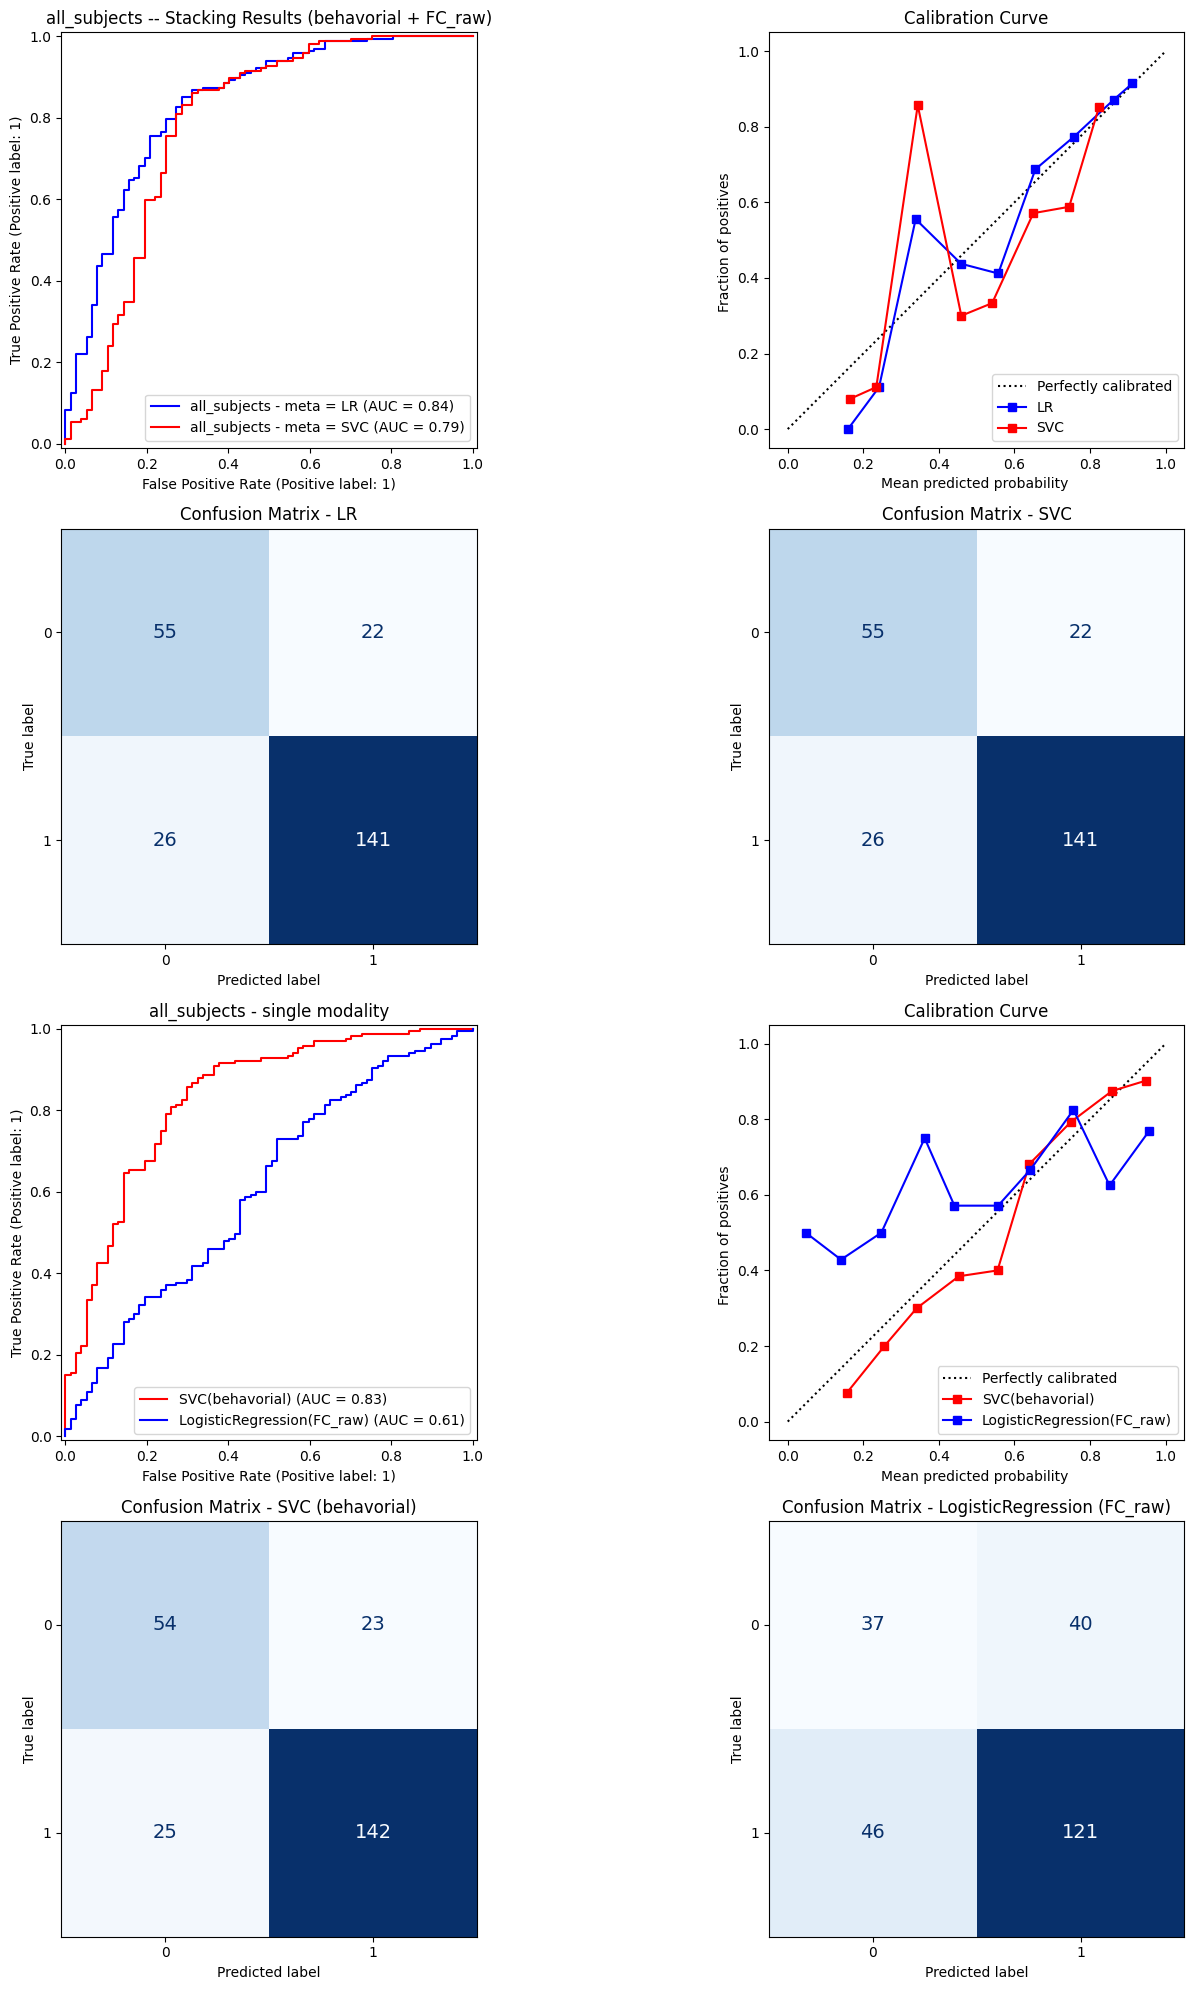

In [ ]:
result_all_subjects_B_rFC, fig_1 = train_and_test_model('behavorial', 'FC_raw', 'all_subjects')
fig_1.savefig(file_path+ '/LF/all_be_fc_raw.png')
with open(file_path+'/LF/all_be_fc_raw.pkl', 'wb') as handle:
    pickle.dump(result_all_subjects_B_rFC, handle)
#behavioral, FC_raw, FC_extracted

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
def plot_precision_recall_curve(result_dict, modality_1, modality_2, cohort):
  stacking_LR = result_dict['stacking - LR']
  stacking_SVC = result_dict['stacking - SVC']
  single_modality_1 = result_dict['single modality - ' + modality_1]
  single_modality_2 = result_dict['single modality - ' + modality_2]
  columns_dict = {
      'behavorial': behavorial_columns_names,
      'FC_raw': raw_FC_columns_names,
      'FC_extracted': reduced_FC_columns_names
  }
  fig, ax = plt.subplots(2,2, figsize=(10, 10))

  # for late fusion classifiers

  LF_data_dict = make_data_dictionary(columns_dict[modality_1] + columns_dict[modality_2])

  LF_test_x, LF_test_y = LF_data_dict[cohort]['test_X'], LF_data_dict[cohort]['test_y']

  disp_LR = PrecisionRecallDisplay.from_estimator(
      stacking_LR, LF_test_x, LF_test_y, plot_chance_level=True, despine=True, ax = ax[0,0]
  )
  #disp_LR.plot(ax = ax[0,0])
  ax[0,0].set_title("Stacking meta classifier: LR " + modality_1 +"+"+ modality_2 +" (" + cohort + ")", fontsize = 10)

  disp_SVC = PrecisionRecallDisplay.from_estimator(
      stacking_SVC, LF_test_x, LF_test_y, plot_chance_level=True, despine=True, ax = ax[0,1]
  )
  #disp_SVC.plot(ax = ax[0,1])
  ax[0,1].set_title("Stacking meta classifier: SVC - " + modality_1 +"+"+ modality_2 +" (" + cohort + ")", fontsize = 10)

  # for single modality
  single_modality_1_dict = make_data_dictionary(columns_dict[modality_1])
  modality_1_test_x, modality_1_test_y = single_modality_1_dict[cohort]['test_X'], single_modality_1_dict[cohort]['test_y']
  disp_single_1 = PrecisionRecallDisplay.from_estimator( single_modality_1, modality_1_test_x, modality_1_test_y, plot_chance_level=True, despine=True,
                                                        ax = ax[1,0])
  #disp_single_1.plot(ax = ax[1,0])
  ax[1,0].set_title("Single modality: " + modality_1 +" (" + cohort + ")")

  single_modality_2_dict = make_data_dictionary(columns_dict[modality_2])
  modality_2_test_x, modality_2_test_y = single_modality_2_dict[cohort]['test_X'], single_modality_2_dict[cohort]['test_y']
  disp_single_2 = PrecisionRecallDisplay.from_estimator( single_modality_2, modality_2_test_x, modality_2_test_y, plot_chance_level=True, despine=True, ax = ax[1,1])
  #disp_single_2.plot(ax = ax[1,1])
  ax[1,1].set_title("Single modality: " + modality_2 +" (" + cohort + ")")

  plt.tight_layout()
  plt.show()


In [ ]:
with open(file_path+'/LF/all_be_fc_raw.pkl', 'rb') as handle:
  result_1 = pickle.load(handle)

plot_precision_recall_curve(result_1, 'behavorial', 'FC_raw', 'all_subjects')


## female

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8980  0.7879  0.8429
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8776  0.7879  0.8327
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8980  0.7879  0.8429
single modality:FC_raw
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.4082  0.7273  0.5677


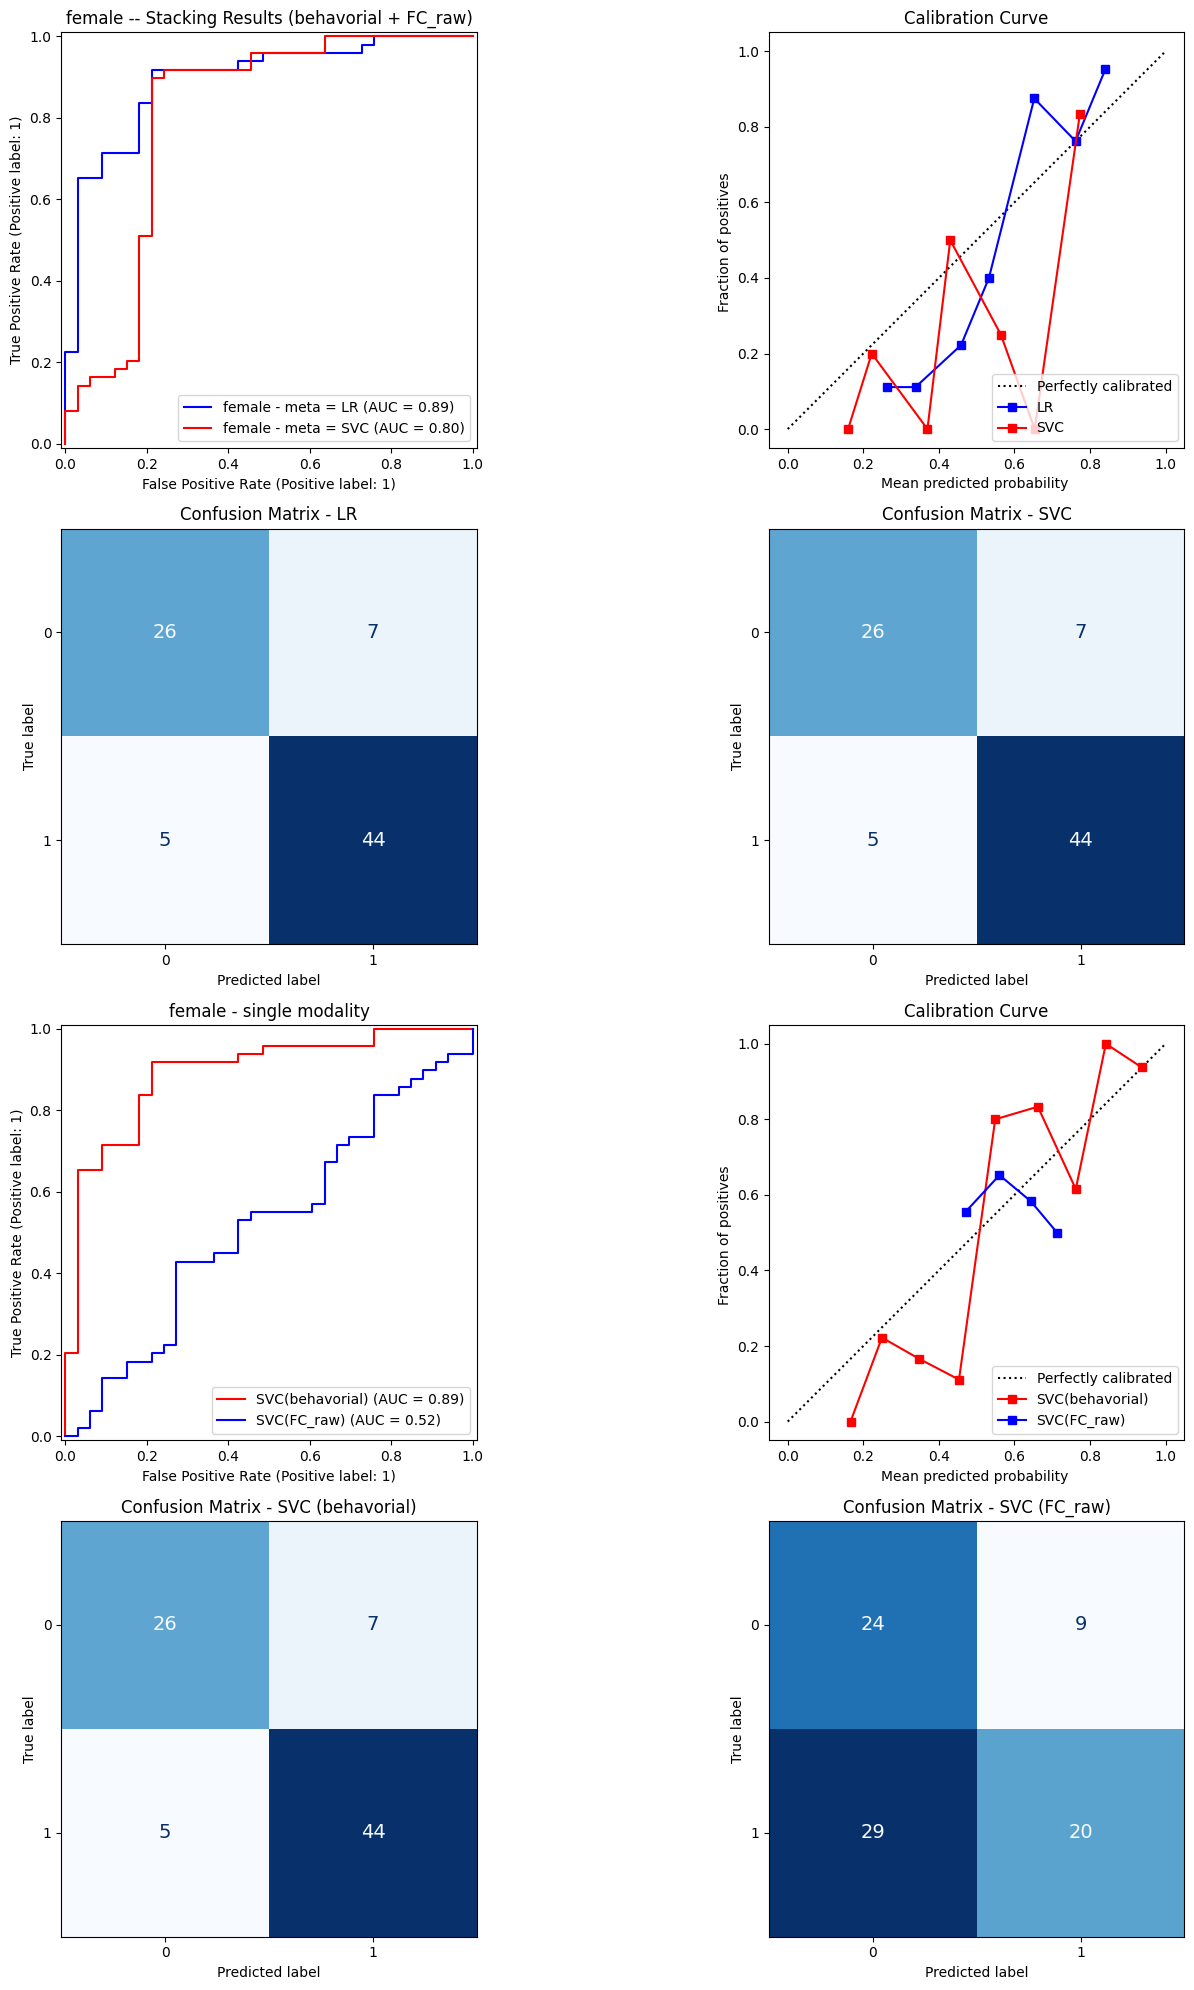

In [ ]:
result_female_B_rFC, fig_2 = train_and_test_model('behavorial', 'FC_raw', 'female')
fig_2.savefig(file_path+ '/LF/female_be_fc_raw.png')
with open(file_path+'/LF/female_be_fc_raw.pkl', 'wb') as handle:
    pickle.dump(result_female_B_rFC, handle)

In [ ]:
with open(file_path+'/LF/female_be_fc_raw.pkl', 'rb') as handle:
  result_2 = pickle.load(handle)
plot_precision_recall_curve(result_2, 'behavorial', 'FC_raw', 'female')

## male

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8475  0.6818  0.7646
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.9153  0.4773  0.6963
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8475  0.6818  0.7646
single modality:FC_raw
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.9831  0.0227  0.5029


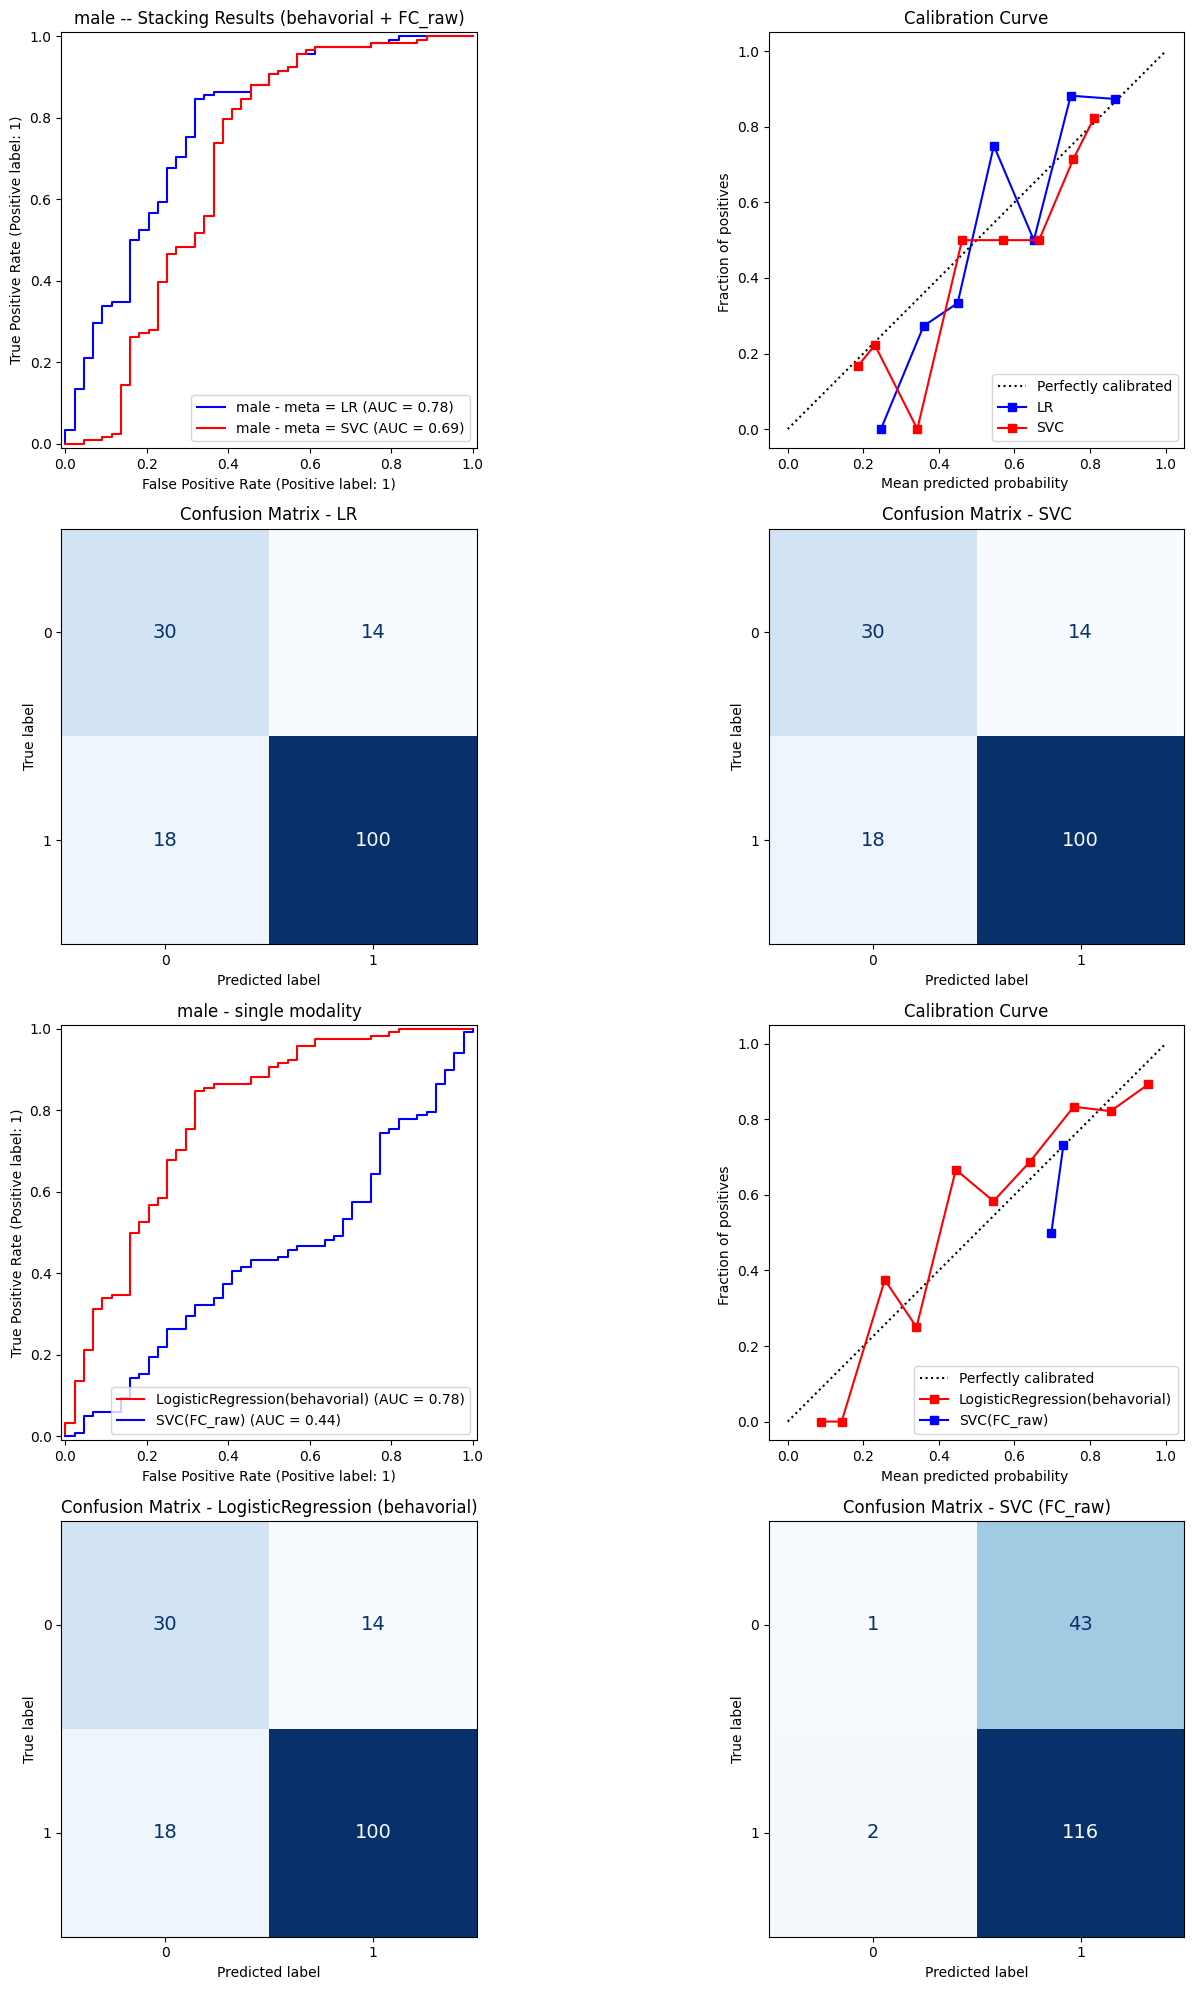

In [ ]:
result_male_B_rFC, fig_3 = train_and_test_model('behavorial', 'FC_raw', 'male')
fig_3.savefig(file_path+ '/LF/male_be_fc_raw.png')
with open(file_path+'/LF/male_be_fc_raw.pkl', 'wb') as handle:
    pickle.dump(result_male_B_rFC, handle)
#behavioral, FC_raw, FC_extracted

In [ ]:
with open(file_path+'/LF/male_be_fc_raw.pkl', 'rb') as handle:
  result_3 = pickle.load(handle)
plot_precision_recall_curve(result_3, 'behavorial', 'FC_raw', 'male')

# behavioral + FC extracted

## all subjects

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8623  0.6883  0.7753
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8743  0.6753  0.7748
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8503  0.7013  0.7758
single modality:FC_extracted
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7365  0.3896  0.5631


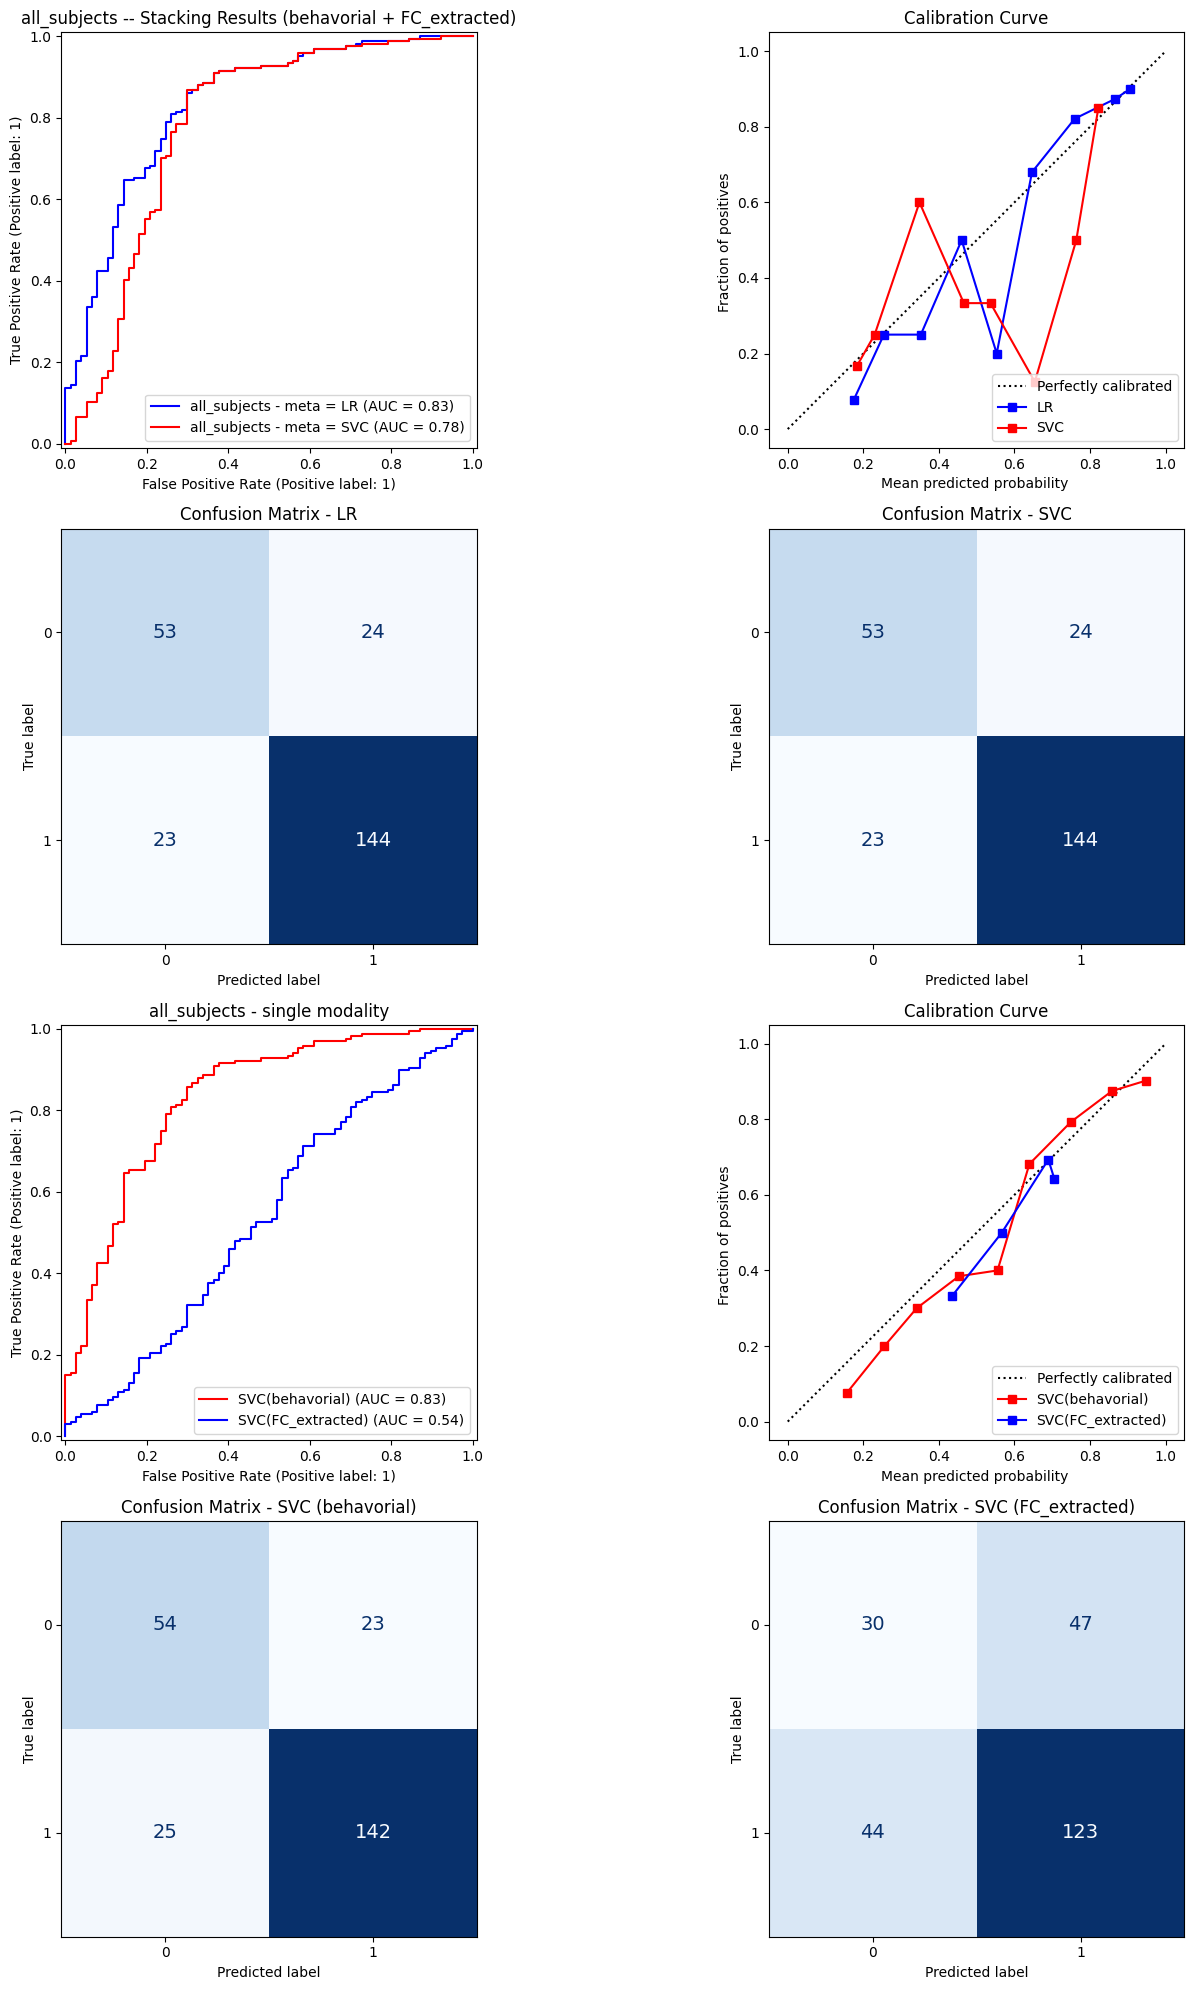

In [ ]:
result_all_subjects_B_exFC, fig_4 = train_and_test_model('behavorial', 'FC_extracted', 'all_subjects')
fig_4.savefig(file_path+ '/LF/all_be_fc_ext.png')
with open(file_path+'/LF/all_be_fc_ext.pkl', 'wb') as handle:
    pickle.dump(result_all_subjects_B_exFC, handle)
#behavioral, FC_raw, FC_extracted

In [ ]:
with open(file_path+'/LF/all_be_fc_ext.pkl', 'rb') as handle:
  result_4 = pickle.load(handle)
plot_precision_recall_curve(result_4, 'behavorial', 'FC_extracted', 'all_subjects')

## female

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8980  0.7879  0.8429
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.9184  0.7879  0.8531
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8980  0.7879  0.8429
single modality:FC_extracted
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8776  0.1515  0.5145


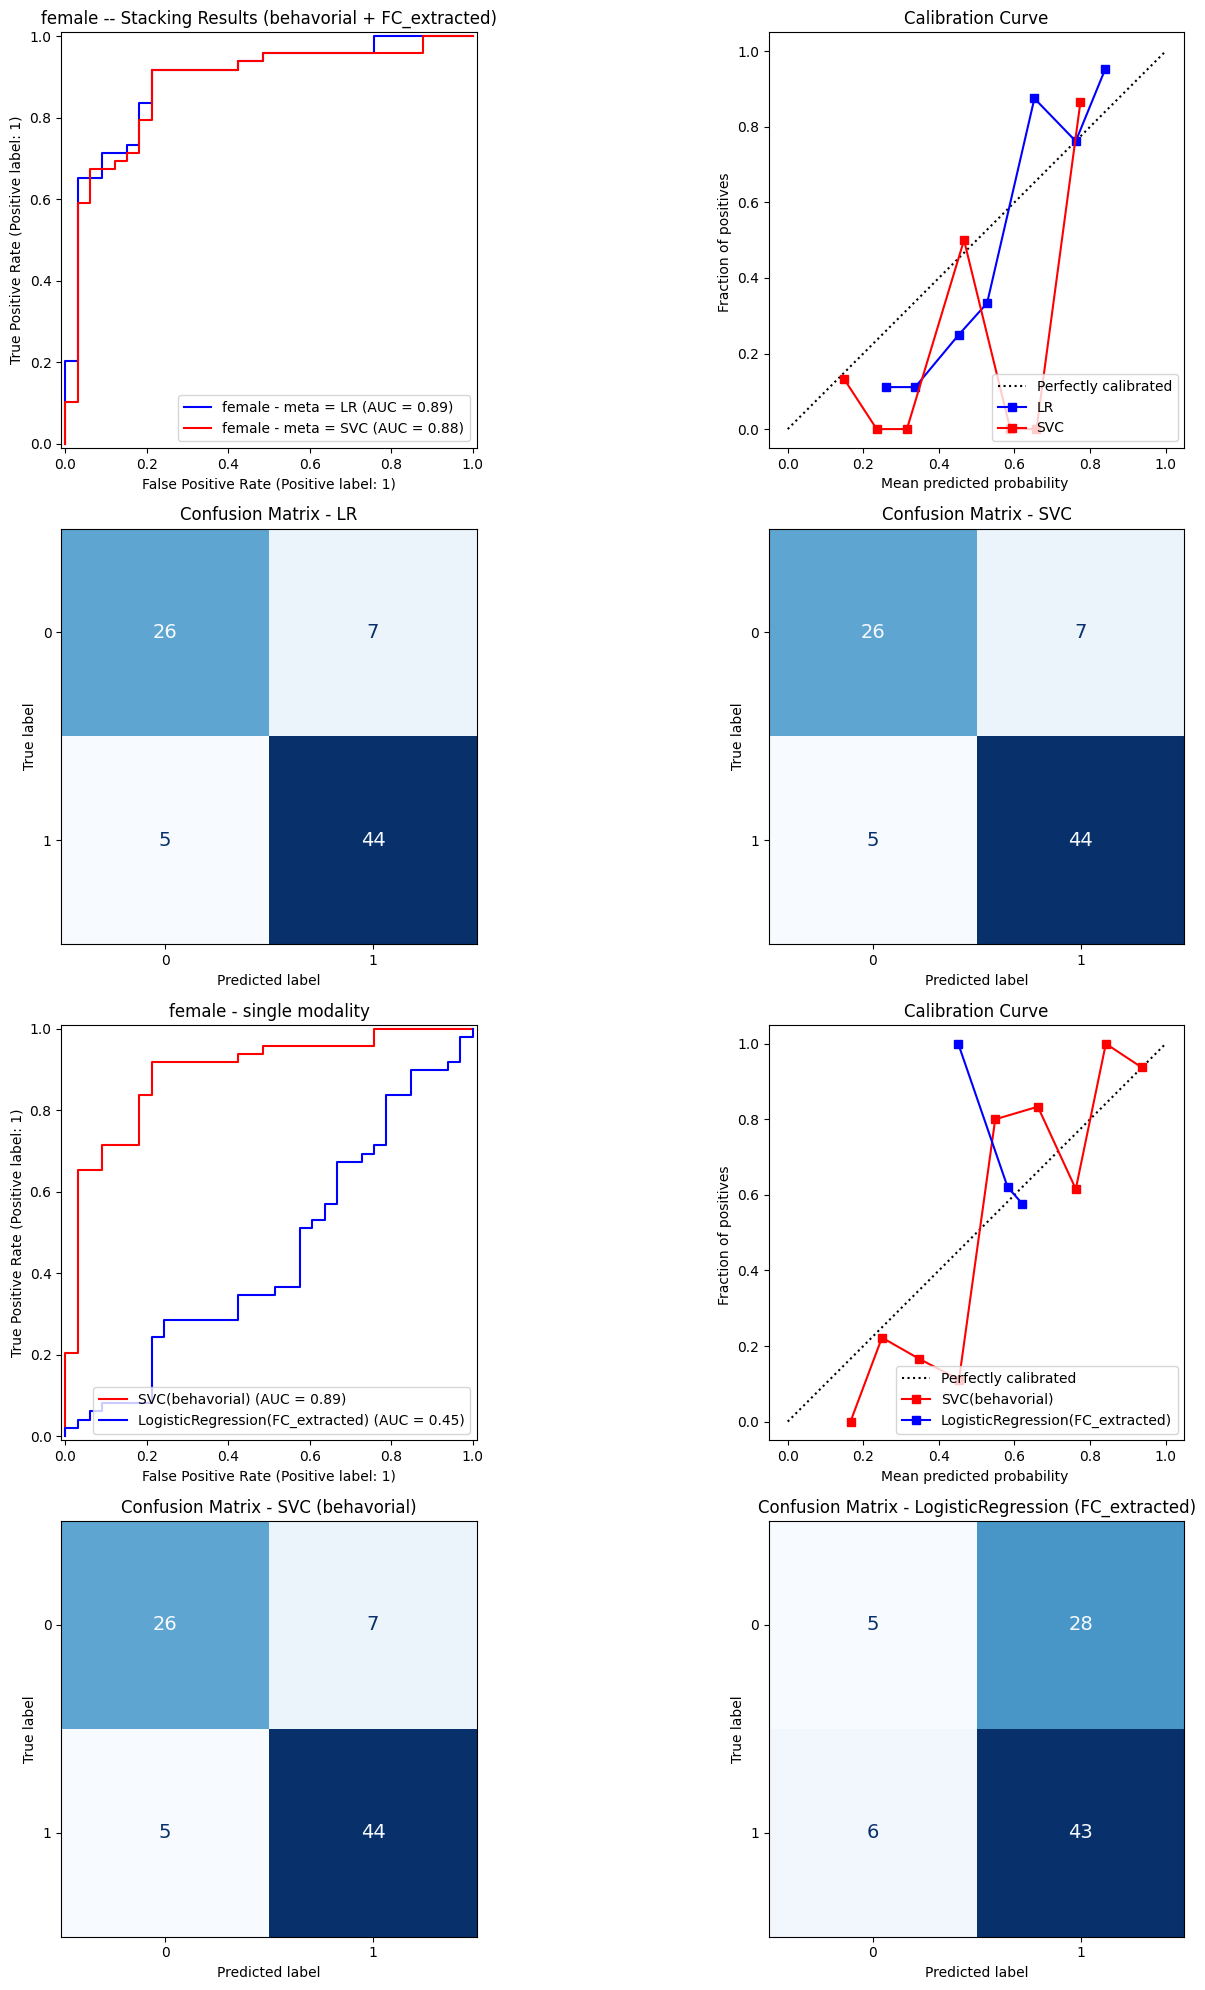

In [ ]:
result_female_exFC, fig_5 = train_and_test_model('behavorial', 'FC_extracted', 'female')
fig_5.savefig(file_path+ '/LF/female_be_fc_ext.png')
with open(file_path+'/LF/female_be_fc_ext.pkl', 'wb') as handle:
    pickle.dump(result_female_exFC, handle)

In [ ]:
with open(file_path+'/LF/female_be_fc_ext.pkl', 'rb') as handle:
  result_5 = pickle.load(handle)
plot_precision_recall_curve(result_4, 'behavorial', 'FC_extracted', 'female')

## male

LF: meta - LR
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8475  0.6818  0.7646
LF: meta - SVC
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8898  0.5227  0.7063
single modality:behavorial
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8475  0.6818  0.7646
single modality:FC_extracted
Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7712  0.2727  0.5220


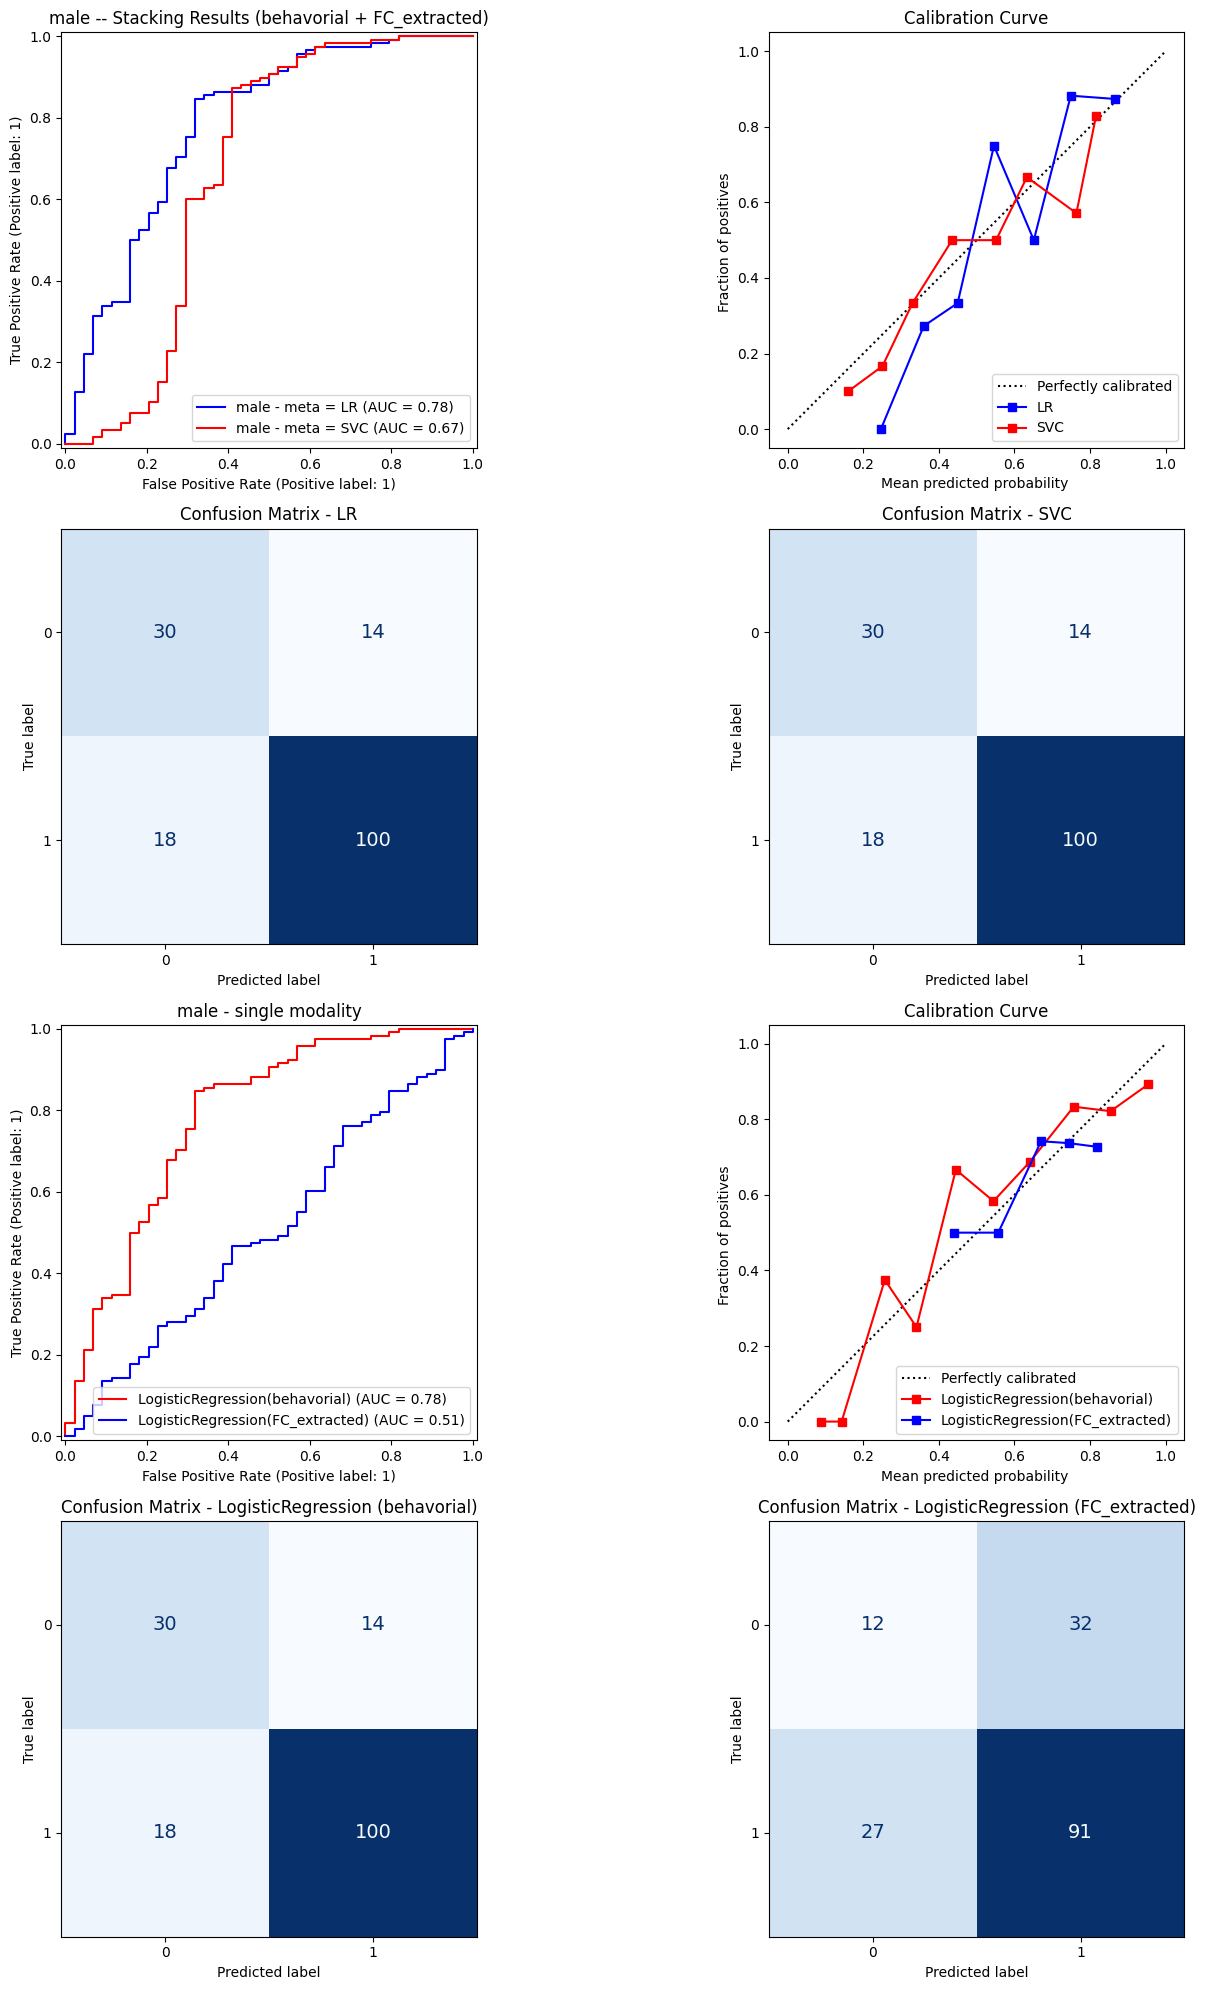

In [ ]:
result_male_exFC, fig_6 = train_and_test_model('behavorial', 'FC_extracted', 'male')
fig_6.savefig(file_path+ '/LF/male_be_fc_ext.png')
with open(file_path+'/LF/male_be_fc_ext.pkl', 'wb') as handle:
    pickle.dump(result_male_exFC, handle)

In [ ]:
with open(file_path+'/LF/male_be_fc_ext.pkl', 'rb') as handle:
  result_6 = pickle.load(handle)
plot_precision_recall_curve(result_4, 'behavorial', 'FC_extracted', 'male')